In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1)

In [2]:
def ds_prep(smi_list):
    char_array = []
    for smi in smi_list:
        char_list = [x for x in smi]
        char_array.append(char_list)
    #char_array = np.array(char_array)
    #char_array = np.reshape(char_array,(len(smi_list),1 , 1))
    return char_array

In [8]:
df = pd.read_csv('aspirin_like.csv', index_col = 0)
df.drop_duplicates('Smiles',inplace = True)
df.shape

(3277, 7)

In [9]:
smiles = df['Smiles'].to_list()
for i in range(len(smiles)): #add newline to each SMILES string
    smiles[i] = smiles[i]+'\n'
smiles[1]

'C1=CC=C(C(=C1)C(=O)O)O[N+](=O)[O-]\n'

In [10]:
max_smi, min_smi = 0, len(smiles[0])

for smi in smiles:
    if len(smi) > max_smi:
        max_smi = len(smi)
    if len(smi) < min_smi:
        min_smi = len(smi)
max_smi, min_smi

(51, 16)

In [11]:
features = []
labels = []

smi_len = 10 # characters from Smiles

for smi in smiles:
    for i in range(smi_len, len(smi)):
        seq = smi[i-smi_len:i + 1]
        features.append(seq[:-1])
        labels.append(seq[1:])
        
features[:5], labels[:5]

(['CC(=O)OC1=', 'C(=O)OC1=C', '(=O)OC1=CC', '=O)OC1=CC=', 'O)OC1=CC=C'],
 ['C(=O)OC1=C', '(=O)OC1=CC', '=O)OC1=CC=', 'O)OC1=CC=C', ')OC1=CC=CC'])

In [12]:
raw_dataset = tf.data.Dataset.from_tensor_slices(smiles)

In [13]:
preprocess = layers.TextVectorization(standardize = None, split = 'character', output_mode = 'int', output_sequence_length = 10)
preprocess.adapt(raw_dataset)

In [14]:
preprocess.get_vocabulary(), preprocess.vocabulary_size()

(['',
  '[UNK]',
  'C',
  '=',
  ')',
  '(',
  'O',
  '1',
  '\n',
  'N',
  '2',
  'F',
  'S',
  ']',
  '[',
  'l',
  '-',
  '+',
  '#',
  'r',
  'B',
  'I',
  '3',
  'P',
  'i',
  'H',
  '5',
  '4'],
 28)

In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
model = tf.keras.Sequential([Embedding(input_dim = len(preprocess.get_vocabulary()),output_dim = 100),
                             LSTM(64, dropout = 0.1, recurrent_dropout = 0.1, return_sequences = True),
                             Dropout(0.5), Dense(len(preprocess.get_vocabulary()))])

model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [16]:
trn_features = preprocess(features)
trn_labels = preprocess(labels)
trn_features

<tf.Tensor: shape=(64964, 10), dtype=int64, numpy=
array([[ 2,  2,  5, ...,  2,  7,  3],
       [ 2,  5,  3, ...,  7,  3,  2],
       [ 5,  3,  6, ...,  3,  2,  2],
       ...,
       [ 4,  2,  5, ...,  4,  6,  4],
       [ 2,  5,  3, ...,  6,  4,  2],
       [ 5,  3,  6, ...,  4,  2, 15]], dtype=int64)>

In [17]:
trn_labels

<tf.Tensor: shape=(64964, 10), dtype=int64, numpy=
array([[ 2,  5,  3, ...,  7,  3,  2],
       [ 5,  3,  6, ...,  3,  2,  2],
       [ 3,  6,  4, ...,  2,  2,  3],
       ...,
       [ 2,  5,  3, ...,  6,  4,  2],
       [ 5,  3,  6, ...,  4,  2, 15],
       [ 3,  6,  4, ...,  2, 15,  8]], dtype=int64)>

In [18]:
model.fit(trn_features, trn_labels, epochs = 25) 

Epoch 1/25
2031/2031 [==============================] - 78s 35ms/step - loss: 1.1725 - accuracy: 0.6150
Epoch 2/25
2031/2031 [==============================] - 68s 34ms/step - loss: 0.9273 - accuracy: 0.6829
Epoch 3/25
2031/2031 [==============================] - 72s 35ms/step - loss: 0.8889 - accuracy: 0.6929
Epoch 4/25
2031/2031 [==============================] - 101s 50ms/step - loss: 0.8702 - accuracy: 0.6973
Epoch 5/25
2031/2031 [==============================] - 79s 39ms/step - loss: 0.8566 - accuracy: 0.6999
Epoch 6/25
2031/2031 [==============================] - 72s 35ms/step - loss: 0.8493 - accuracy: 0.7017
Epoch 7/25
2031/2031 [==============================] - 69s 34ms/step - loss: 0.8422 - accuracy: 0.7038
Epoch 8/25
2031/2031 [==============================] - 69s 34ms/step - loss: 0.8365 - accuracy: 0.7043
Epoch 9/25
2031/2031 [==============================] - 69s 34ms/step - loss: 0.8325 - accuracy: 0.7057
Epoch 10/25
2031/2031 [==============================] - 69s 34

In [37]:
def gen_mol(smi_str, model, text_vect, gen_length):
    model.reset_states()
    
    gen_str = smi_str
    start_str = gen_str
    
    for i in range(gen_length):
        start_vect = text_vect([start_str])
        
        logits = model(start_vect)
        logits = tf.squeeze(logits,0)
        
        new_char_index = tf.random.categorical(logits, num_samples = 1)
        new_char_index = tf.squeeze(new_char_index)[-1].numpy()
        new_char = text_vect.get_vocabulary()[new_char_index]        
        
        gen_str += new_char
        start_str = start_str[1:] + new_char
    
    return gen_str    

In [38]:
input_text = 'C1CCCCCCC1' #look into padding
gen_length = 300
predictions = gen_mol(input_text,model,preprocess,gen_length)

In [41]:
gen_smi = predictions.split('\n')
len(gen_smi)

25

In [52]:
from rdkit import Chem
from rdkit.Chem import DetectChemistryProblems
from rdkit.Chem import Draw

clean_mol = []
for smi in gen_smi:
    mol = Chem.MolFromSmiles(smi)
    if mol is None or len(DetectChemistryProblems(mol)) != 0: continue
    clean_mol.append(mol)
len(clean_mol)

[17:29:37] SMILES Parse Error: unclosed ring for input: 'CC(C=CC(=C1)O)C(=O)O'
[17:29:37] SMILES Parse Error: syntax error while parsing: )Cl)C(=O)O)C(=O)O
[17:29:37] SMILES Parse Error: Failed parsing SMILES ')Cl)C(=O)O)C(=O)O' for input: ')Cl)C(=O)O)C(=O)O'
[17:29:37] SMILES Parse Error: syntax error while parsing: Nl
[17:29:37] SMILES Parse Error: Failed parsing SMILES 'Nl' for input: 'Nl'
[17:29:37] SMILES Parse Error: extra close parentheses while parsing: C(=O)O)NC(=O)Cl
[17:29:37] SMILES Parse Error: Failed parsing SMILES 'C(=O)O)NC(=O)Cl' for input: 'C(=O)O)NC(=O)Cl'
[17:29:37] SMILES Parse Error: syntax error while parsing: )C(=O)O
[17:29:37] SMILES Parse Error: Failed parsing SMILES ')C(=O)O' for input: ')C(=O)O'
[17:29:37] SMILES Parse Error: syntax error while parsing: )Cl
[17:29:37] SMILES Parse Error: Failed parsing SMILES ')Cl' for input: ')Cl'
[17:29:37] SMILES Parse Error: extra close parentheses while parsing: I)C(=O)OC
[17:29:37] SMILES Parse Error: Failed parsing SM

11

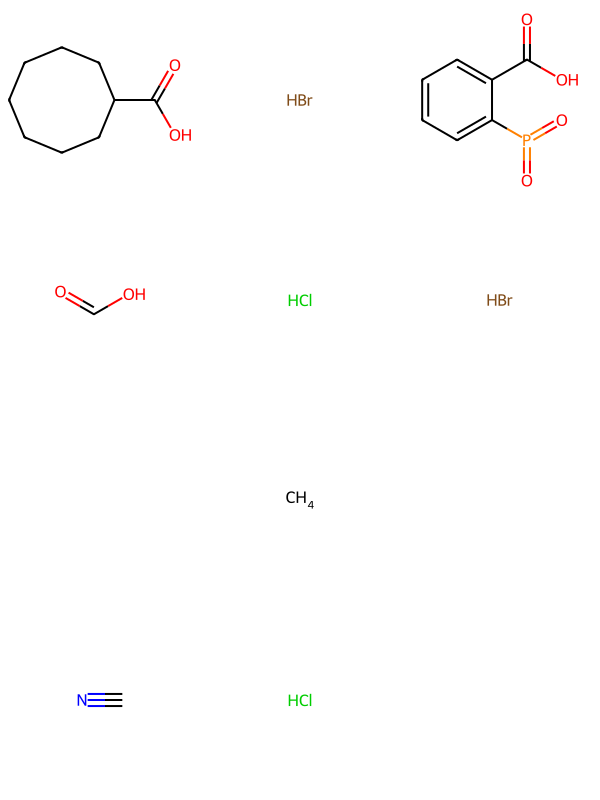

In [53]:
Draw.MolsToGridImage(clean_mol)